In [ ]:
#! pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
%tensorflow_version 1.x

from google.colab import drive

try:
  drive.mount("/content/drive")
except:
  pass

import sys

PATH = '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211'
sys.path.append(PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import numpy as np
from gensim.models import Word2Vec, FastText
import matplotlib.pyplot as plt
import seaborn as sns
# import glove
# from glove import Corpus

import collections
import gc 

import keras
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, Input, concatenate, merge, Activation, Concatenate, LSTM, GRU
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, BatchNormalization, GRU, Convolution1D, LSTM
from keras.layers import UpSampling1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D,MaxPool1D
from keras.layers import Concatenate

from keras.optimizers import Adam, SGD, Adagrad

from keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau
from keras.utils import np_utils
from keras.backend.tensorflow_backend import set_session, clear_session, get_session
import tensorflow as tf

tf.disable_v2_behavior() 


from sklearn.utils import class_weight
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

#Second run with no changes
# SEED='test'

#Second run with LOS>2,4,5
# SEED=245

# #Second run with SGD optimizer
# SEED='sgd'

#Second run with AdaGrad optimizer
SEED='adagrad'

# #Second run with 100epochs
# SEED='100epochs'

#Second run with AdaGrad optimizer
SEED='normal'

#Second run 100 epochs, early stopping model patience from 5 to 10, dropout=0.5
SEED='test2'

# #Second run with AdaGrad optimizer,100 epochs, 5 iter and stride=2
# SEED='100epochs'

# #Second run with AdaGrad optimizer,100 epochs, stride=1, kernal=2
SEED='100epochsstride1kernel2'

In [ ]:
type_of_ner = "new"

x_train_lstm = pd.read_pickle(PATH + "/data/"+type_of_ner+"_x_train.pkl")
x_dev_lstm = pd.read_pickle(PATH + "/data/"+type_of_ner+"_x_dev.pkl")
x_test_lstm = pd.read_pickle(PATH + "/data/"+type_of_ner+"_x_test.pkl")

y_train = pd.read_pickle(PATH + "/data/"+type_of_ner+"_y_train.pkl")
y_dev = pd.read_pickle(PATH + "/data/"+type_of_ner+"_y_dev.pkl")
y_test = pd.read_pickle(PATH + "/data/"+type_of_ner+"_y_test.pkl")


ner_word2vec = pd.read_pickle(PATH + "/data/"+type_of_ner+"_ner_word2vec_limited_dict.pkl")
ner_fasttext = pd.read_pickle(PATH + "/data/"+type_of_ner+"_ner_fasttext_limited_dict.pkl")
ner_concat = pd.read_pickle(PATH + "/data/"+type_of_ner+"_ner_combined_limited_dict.pkl")

train_ids = pd.read_pickle(PATH + "/data/"+type_of_ner+"_train_ids.pkl")
dev_ids = pd.read_pickle(PATH + "/data/"+type_of_ner+"_dev_ids.pkl")
test_ids = pd.read_pickle(PATH + "/data/"+type_of_ner+"_test_ids.pkl")

In [ ]:
y_train.columns

Index(['mort_hosp', 'mort_icu', 'los_2', 'los_4', 'los_5', 'los_3', 'los_7'], dtype='object')

In [ ]:
mort_hosp_vc = y_train['mort_hosp'].value_counts()
mort_icu_vc = y_train['mort_icu'].value_counts()
los_3_vc = y_train['los_3'].value_counts()
los_7_vc = y_train['los_7'].value_counts()

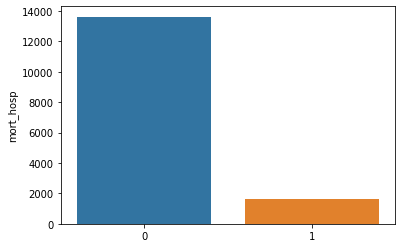

In [ ]:


sns.barplot(x=y_train.mort_hosp.value_counts().index, y=y_train.mort_hosp.value_counts())


In [ ]:
# print(len(ner_concat.keys()))
# print(len(ner_word2vec.keys()))
# print(len(train_ids))


In [ ]:
def make_prediction_cnn(model, test_data):
    probs = model.predict(test_data)
    y_pred = [1 if i>=0.5 else 0 for i in probs]
    return probs, y_pred

def save_scores_cnn(predictions, probs, ground_truth, 
                          
                          embed_name, problem_type, iteration, hidden_unit_size,
                          
                          sequence_name, type_of_ner):
    
    auc = roc_auc_score(ground_truth, probs)
    auprc = average_precision_score(ground_truth, probs)
    acc   = accuracy_score(ground_truth, predictions)
    F1    = f1_score(ground_truth, predictions)
    
    result_dict = {}    
    result_dict['auc'] = auc
    result_dict['auprc'] = auprc
    result_dict['acc'] = acc
    result_dict['F1'] = F1

    result_path = PATH + f"/results/proposed/{SEED}/"
    file_name = str(sequence_name)+"-"+str(hidden_unit_size)+"-"+embed_name
    file_name = file_name +"-"+problem_type+"-"+str(iteration)+"-"+type_of_ner+ f"-cnn-{SEED}.p"
    pd.to_pickle(result_dict, os.path.join(result_path, file_name))

    print(auc, auprc, acc, F1)
    
def print_scores_cnn(predictions, probs, ground_truth, model_name, problem_type, iteration, hidden_unit_size):
    auc = roc_auc_score(ground_truth, probs)
    auprc = average_precision_score(ground_truth, probs)
    acc   = accuracy_score(ground_truth, predictions)
    F1    = f1_score(ground_truth, predictions)
    
    print ("AUC: ", auc, "AUPRC: ", auprc, "F1: ", F1)
    
def get_subvector_data(size, embed_name, data):
    if embed_name == "concat":
        vector_size = 200
    else:
        vector_size = 100

    x_data = {}
    for k, v in data.items():
        number_of_additional_vector = len(v) - size
        vector = []
        for i in v:
            vector.append(i)
        if number_of_additional_vector < 0: 
            number_of_additional_vector = np.abs(number_of_additional_vector)

            temp = vector[:size]
            for i in range(0, number_of_additional_vector):
                temp.append(np.zeros(vector_size))
            x_data[k] = np.asarray(temp)
        else:
            x_data[k] = np.asarray(vector[:size])

    return x_data


def proposedmodel(layer_name, number_of_unit, embedding_name, ner_limit, num_filter):
    if embedding_name == "concat":
        input_dimension = 200
    else:
        input_dimension = 100

    sequence_input = Input(shape=(24,104))

    input_img = Input(shape=(ner_limit, input_dimension), name = "cnn_input")

    convs = []
    filter_sizes = [2,3,4]

    text_conv1d = Conv1D(filters=num_filter, kernel_size=2, 
                 padding = 'valid', strides = 1, dilation_rate=1, activation='relu')(input_img)
    
    text_conv1d = Conv1D(filters=num_filter*2, kernel_size=2, 
                 padding = 'valid', strides = 1, dilation_rate=1, activation='relu')(text_conv1d)   
    
    text_conv1d = Conv1D(filters=num_filter*3, kernel_size=2, 
                 padding = 'valid', strides = 1, dilation_rate=1, activation='relu')(text_conv1d)   


    
    #concat_conv = keras.layers.Concatenate()([text_conv1d, text_conv1d_2, text_conv1d_3])
    text_embeddings = GlobalMaxPooling1D()(text_conv1d)
    #text_embeddings = Dense(128, activation="relu")(text_embeddings)
    
    if layer_name == "GRU":
        x = GRU(number_of_unit)(sequence_input)
    elif layer_name == "LSTM":
        x = LSTM(number_of_unit)(sequence_input)

    #concatenated = keras.layers.Concatenate()([x, text_embeddings])
    concatenated = keras.layers.Concatenate(axis=1)([x, text_embeddings])

    concatenated = Dense(512, activation='relu')(concatenated)
    concatenated = Dropout(0.5)(concatenated)
    #concatenated = Dense(256, activation='relu')(concatenated)
    #concatenated = Dense(512, activation='relu')(concatenated)
    
    #concatenated = Dense(512, activation='relu')(concatenated)
    logits_regularizer = tf.contrib.layers.l2_regularizer(scale=0.01)
    preds = Dense(1, activation='sigmoid',use_bias=False, kernel_regularizer=logits_regularizer)(concatenated)
    
    
    #opt = Adam(lr=1e-4, decay = 0.01)
    
    opt = Adam(lr=1e-3, decay = 0.01)
    # opt = SGD(lr=1e-3, decay = 0.01)
    # opt = Adagrad(lr=1e-3, decay = 0.01)
    #opt = Adam(lr=0.001)

    model = Model(inputs=[sequence_input, input_img], outputs=preds)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    
    return model


In [ ]:
embedding_types = ['word2vec', 'fasttext', 'concat']
embedding_dict = [ner_word2vec, ner_fasttext, ner_concat]

target_problems = ['mort_hosp', 'mort_icu', 'los_3', 'los_7']
# target_problems = ['mort_hosp', 'mort_icu', 'los_3', 'los_7','los_2', 'los_4','los_5']

num_epoch = 100
model_patience = 10
monitor_criteria = 'val_loss'
#monitor_criteria = 'val_acc'
batch_size = 64

filter_number = 32
ner_representation_limit = 64
activation_func = "relu"

sequence_model = "GRU"
sequence_hidden_unit = 256

# model = proposedmodel(sequence_model, sequence_hidden_unit, 'mort_hosp', ner_representation_limit,filter_number)
# print(model.summary())


maxiter = 11
for embed_dict, embed_name in zip(embedding_dict, embedding_types):    
    print ("Embedding: ", embed_name)
    print("=============================")
    
    temp_train_ner = dict((k, embed_dict[k]) for k in train_ids)
    tem_dev_ner = dict((k, embed_dict[k]) for k in dev_ids)
    temp_test_ner = dict((k, embed_dict[k]) for k in test_ids)

    x_train_dict = {}
    x_dev_dict = {}
    x_test_dict = {}

    x_train_dict = get_subvector_data(ner_representation_limit, embed_name, temp_train_ner)
    x_dev_dict = get_subvector_data(ner_representation_limit, embed_name, tem_dev_ner)
    x_test_dict = get_subvector_data(ner_representation_limit, embed_name, temp_test_ner)


    x_train_dict_sorted = collections.OrderedDict(sorted(x_train_dict.items()))
    x_dev_dict_sorted = collections.OrderedDict(sorted(x_dev_dict.items()))
    x_test_dict_sorted = collections.OrderedDict(sorted(x_test_dict.items()))


    x_train_ner = np.asarray(list(x_train_dict_sorted.values()))
    x_dev_ner = np.asarray(list(x_dev_dict_sorted.values()))
    x_test_ner = np.asarray(list(x_test_dict_sorted.values()))


        
    for iteration in range(1,maxiter):
        print ("Iteration number: ", iteration)
    
        for each_problem in target_problems:
            print ("Problem type: ", each_problem)
            print ("__________________")
            
            
            early_stopping_monitor = EarlyStopping(monitor=monitor_criteria, patience=model_patience)
            
            best_model_name = str(ner_representation_limit)+"-basiccnn1d-"+str(embed_name)+"-"+str(each_problem)+"-"+"best_model.hdf5"
            
            checkpoint = ModelCheckpoint(best_model_name, monitor=monitor_criteria, verbose=1, save_best_only=True, mode='min')
            
            reduce_lr = ReduceLROnPlateau(monitor=monitor_criteria, factor=0.2, patience=2, min_lr=0.00001, epsilon=1e-4, mode='min')
            

            callbacks = [early_stopping_monitor, checkpoint, reduce_lr]
            
            #model = textCNN(sequence_model, sequence_hidden_unit, embed_name, ner_representation_limit)
            model = proposedmodel(sequence_model, sequence_hidden_unit, embed_name, ner_representation_limit,filter_number)
            
            model.fit([x_train_lstm, x_train_ner], y_train[each_problem], epochs=num_epoch, verbose=1, 
                      validation_data=([x_dev_lstm, x_dev_ner], y_dev[each_problem]), callbacks=callbacks, batch_size=batch_size)
            
            probs, predictions = make_prediction_cnn(model, [x_test_lstm, x_test_ner])
            print_scores_cnn(predictions, probs, y_test[each_problem], embed_name, each_problem, iteration, sequence_hidden_unit)
            
            model.load_weights(best_model_name)
                      
            probs, predictions = make_prediction_cnn(model, [x_test_lstm, x_test_ner])
            save_scores_cnn(predictions, probs, y_test[each_problem], embed_name, each_problem, iteration,
                            sequence_hidden_unit, sequence_model, type_of_ner)
            del model
            clear_session()
            gc.collect()
            
    

Streaming output truncated to the last 5000 lines.
Epoch 7/100
15219/15219 [==============================] - 6s 415us/step - loss: 0.5745 - acc: 0.7127 - val_loss: 0.6107 - val_acc: 0.6733

Epoch 00007: val_loss did not improve from 0.61052
Epoch 8/100
15219/15219 [==============================] - 6s 411us/step - loss: 0.5707 - acc: 0.7142 - val_loss: 0.6114 - val_acc: 0.6724

Epoch 00008: val_loss did not improve from 0.61052
Epoch 9/100
15219/15219 [==============================] - 6s 402us/step - loss: 0.5721 - acc: 0.7094 - val_loss: 0.6115 - val_acc: 0.6719

Epoch 00009: val_loss did not improve from 0.61052
Epoch 10/100
15219/15219 [==============================] - 6s 404us/step - loss: 0.5709 - acc: 0.7127 - val_loss: 0.6115 - val_acc: 0.6724

Epoch 00010: val_loss did not improve from 0.61052
Epoch 11/100
15219/15219 [==============================] - 6s 392us/step - loss: 0.5688 - acc: 0.7104 - val_loss: 0.6116 - val_acc: 0.6724

Epoch 00011: val_loss did not improve from 

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/normal/GRU-256-concat-los_3-9-new-cnn-normal.p')
df

{'F1': 0.5667543090855974,
 'acc': 0.6589236430542779,
 'auc': 0.7016808880717156,
 'auprc': 0.6426832087540619}

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/test/GRU-256-concat-mort_hosp-4-new-cnn-test.p')
df

{'F1': 0.41214057507987223,
 'acc': 0.9153633854645814,
 'auc': 0.8774792933298088,
 'auprc': 0.5697726831784654}

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/2/GRU-256-concat-los_3-1-new-cnn-2.p')
df

{'F1': 0.331511839708561,
 'acc': 0.7467801287948482,
 'auc': 0.7110129946658318,
 'auprc': 0.4975533822749475}

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/'

In [ ]:
subfolders = [ f.path for f in os.scandir(PATH) if f.is_dir() ]
subfolders

['/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/2',
 '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/.ipynb_checkpoints',
 '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/test',
 '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/245',
 '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/sgd',
 '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/adagrad',
 '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/normal',
 '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/100epochsstride2',
 '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/100epochs',
 '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/100epochsstride1kernel2']

In [ ]:
import glob
from pathlib import Path

results_dict = {'experiment':[],'embedding':[],'target_problem':[],'F1':[],'acc':[],'auc':[],'auprc':[]}

for path in subfolders:
  folder_name = path.split('/')[-1]
  exclude_list = ['test','.ipynb_checkpoints']
  if folder_name not in exclude_list:
    files = glob.glob(f"{path}/*.p")
    for file in files:
      file_name = Path(file).stem
      file_name_items = file_name.split('-')
      results_dict['experiment'].append(file_name_items[-1])
      results_dict['embedding'].append(file_name_items[2])
      results_dict['target_problem'].append(file_name_items[3])
      scores_dict = pd.read_pickle(file)
      results_dict['acc'].append(scores_dict['acc'])
      results_dict['auc'].append(scores_dict['auc'])
      results_dict['auprc'].append(scores_dict['auprc'])
      results_dict['F1'].append(scores_dict['F1'])


In [ ]:
df=pd.DataFrame.from_dict(results_dict,orient='index').transpose()

In [ ]:
df.shape

(776, 7)

In [ ]:
df.columns

Index(['experiment', 'embedding', 'target_problem', 'F1', 'acc', 'auc',
       'auprc'],
      dtype='object')

In [ ]:
df_groupby = df.groupby(['experiment','target_problem','embedding']).agg({'auc':['mean'],'auprc':['mean'], 'F1':['mean']})

In [ ]:
df_groupby_new = df.groupby(['experiment','target_problem','embedding']).agg({'auc':['mean'],'auprc':['mean'], 'F1':['mean']}).reset_index()

In [ ]:
new_columns = []
for i in df_groupby_new.columns:
  j=''
  if i[1]:
    j='_'.join(list(i))
  else:
    j=i[0]
  new_columns.append(j)

df_groupby_new.columns = new_columns

In [ ]:
df_groupby_new

,experiment,target_problem,embedding,auc_mean,auprc_mean,F1_mean
0,100epochs,los_3,concat,0.696942,0.639572,0.557060
1,100epochs,los_3,fasttext,0.695546,0.637987,0.546487
2,100epochs,los_3,word2vec,0.702856,0.646159,0.554279
3,100epochs,los_7,concat,0.723209,0.213898,0.026217
4,100epochs,los_7,fasttext,0.722359,0.215645,0.021812
...,...,...,...,...,...,...
88,sgd,mort_hosp,fasttext,0.576084,0.132955,0.017994
89,sgd,mort_hosp,word2vec,0.558783,0.125584,0.015573
90,sgd,mort_icu,concat,0.586962,0.094137,0.015855
91,sgd,mort_icu,fasttext,0.561639,0.087178,0.004639


In [ ]:
df_normal = df_groupby_new.loc[df_groupby_new['experiment'] == 'normal']
df_sqd = df_groupby_new.loc[df_groupby_new['experiment'] == 'sgd']
df_adagrad = df_groupby_new.loc[df_groupby_new['experiment'] == 'adagrad']
df_100epochs = df_groupby_new.loc[df_groupby_new['experiment'] == '100epochs']
df_245 = df_groupby_new.loc[df_groupby_new['experiment'] == '245']
df_adagrad = df_groupby_new.loc[df_groupby_new['experiment'] == 'adagrad']

In [ ]:
df_normal=df_normal.loc[:, df_normal.columns != 'experiment']
df_normal

,target_problem,embedding,auc_mean,auprc_mean,F1_mean
69,los_3,concat,0.698851,0.642141,0.545265
70,los_3,fasttext,0.698344,0.639995,0.548365
71,los_3,word2vec,0.700578,0.644681,0.554912
72,los_7,concat,0.725391,0.219396,0.022405
73,los_7,fasttext,0.724053,0.217388,0.020778
74,los_7,word2vec,0.731378,0.223075,0.024398
75,mort_hosp,concat,0.877271,0.574856,0.464331
76,mort_hosp,fasttext,0.879019,0.576782,0.459373
77,mort_hosp,word2vec,0.879672,0.577347,0.465998
78,mort_icu,concat,0.883721,0.517053,0.428733


In [ ]:
df_100epochs=df_100epochs.loc[:, df_100epochs.columns != 'experiment']
df_100epochs

,target_problem,embedding,auc_mean,auprc_mean,F1_mean
0,los_3,concat,0.696942,0.639572,0.557060
1,los_3,fasttext,0.695546,0.637987,0.546487
2,los_3,word2vec,0.702856,0.646159,0.554279
3,los_7,concat,0.723209,0.213898,0.026217
4,los_7,fasttext,0.722359,0.215645,0.021812
5,los_7,word2vec,0.729062,0.222069,0.023015
6,mort_hosp,concat,0.876252,0.573842,0.464079
7,mort_hosp,fasttext,0.875623,0.572135,0.457141
8,mort_hosp,word2vec,0.878432,0.576991,0.458677
9,mort_icu,concat,0.882777,0.515274,0.431841


In [ ]:
df_adagrad=df_adagrad.loc[:, df_adagrad.columns != 'experiment']
df_adagrad

,target_problem,embedding,auc_mean,auprc_mean,F1_mean
57,los_3,concat,0.678296,0.617381,0.522078
58,los_3,fasttext,0.674581,0.613289,0.521263
59,los_3,word2vec,0.683896,0.624097,0.529454
60,los_7,concat,0.682707,0.171536,0.021611
61,los_7,fasttext,0.681890,0.169245,0.019993
62,los_7,word2vec,0.701438,0.182604,0.017375
63,mort_hosp,concat,0.847946,0.493719,0.367432
64,mort_hosp,fasttext,0.844625,0.491450,0.379610
65,mort_hosp,word2vec,0.850039,0.501382,0.384896
66,mort_icu,concat,0.849913,0.446016,0.346974


In [ ]:
df_sqd=df_sqd.loc[:, df_sqd.columns != 'experiment']
df_sqd

,target_problem,embedding,auc_mean,auprc_mean,F1_mean
81,los_3,concat,0.554553,0.483578,0.339426
82,los_3,fasttext,0.553877,0.484391,0.344288
83,los_3,word2vec,0.578365,0.508708,0.339295
84,los_7,concat,0.488618,0.079813,0.006595
85,los_7,fasttext,0.475995,0.078126,0.008837
86,los_7,word2vec,0.496917,0.084475,0.012396
87,mort_hosp,concat,0.599242,0.136894,0.015735
88,mort_hosp,fasttext,0.576084,0.132955,0.017994
89,mort_hosp,word2vec,0.558783,0.125584,0.015573
90,mort_icu,concat,0.586962,0.094137,0.015855


In [ ]:
df_245=df_245.loc[:, df_245.columns != 'experiment']
df_245 = df_245.loc[df_245['target_problem'].isin(['los_2','los_4','los_5'])]
df_245

,target_problem,embedding,auc_mean,auprc_mean,F1_mean
36,los_2,concat,0.689562,0.840409,0.823997
37,los_2,fasttext,0.683915,0.838757,0.823154
38,los_2,word2vec,0.689951,0.842280,0.822231
42,los_4,concat,0.709628,0.494413,0.351558
43,los_4,fasttext,0.709497,0.492975,0.372847
44,los_4,word2vec,0.715186,0.495963,0.369771
45,los_5,concat,0.718649,0.389336,0.238959
46,los_5,fasttext,0.716589,0.385862,0.239216
47,los_5,word2vec,0.722970,0.388038,0.249167


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/CS598_DLH_Paper211/results/proposed/normal'

In [ ]:
import glob
from pathlib import Path

results_dict = {'target_problem':[],'embeddings':[], 'F1':[],'acc':[],'auc':[],'auprc':[]}


files = glob.glob(f"{PATH}/*.p")
print(len(files))
for file in files:
  file_name = Path(file).stem
  file_name_items = file_name.split('-')
  results_dict['target_problem'].append(file_name_items[3])
  results_dict['embeddings'].append(file_name_items[2])
  scores_dict = pd.read_pickle(file)
  results_dict['acc'].append(scores_dict['acc'])
  results_dict['auc'].append(scores_dict['auc'])
  results_dict['auprc'].append(scores_dict['auprc'])
  results_dict['F1'].append(scores_dict['F1'])

120


In [ ]:
df=pd.DataFrame.from_dict(results_dict,orient='index').transpose()
df.head()

,target_problem,embeddings,F1,acc,auc,auprc
0,mort_hosp,word2vec,0.455474,0.914213,0.874667,0.565536
1,mort_icu,word2vec,0.444444,0.940202,0.890593,0.524216
2,los_3,word2vec,0.588742,0.670653,0.703473,0.649201
3,los_7,word2vec,0.016667,0.918583,0.73082,0.22275
4,mort_hosp,word2vec,0.466276,0.916283,0.879865,0.580742


In [ ]:
df_groupby = df.groupby(['target_problem']).agg({'auc':['mean'],'auprc':['mean'], 'F1':['mean']})

In [ ]:
df_groupby_new = df.groupby(['target_problem','embeddings']).agg({'auc':['mean'],'auprc':['mean'], 'F1':['mean']}).reset_index()

In [ ]:
new_columns = []
for i in df_groupby_new.columns:
  j=''
  if i[1]:
    j='_'.join(list(i))
  else:
    j=i[0]
  new_columns.append(j)

df_groupby_new.columns = new_columns

In [ ]:

df_groupby_new['auc_mean'] = df_groupby_new['auc_mean'].multiply(100).round(2)
df_groupby_new['auprc_mean'] = df_groupby_new['auprc_mean'].multiply(100).round(2)
df_groupby_new['F1_mean'] = df_groupby_new['F1_mean'].multiply(100).round(2)
df_groupby_new

,target_problem,embeddings,auc_mean,auprc_mean,F1_mean
0,los_3,concat,69.89,64.21,54.53
1,los_3,fasttext,69.83,64.00,54.84
2,los_3,word2vec,70.06,64.47,55.49
3,los_7,concat,72.54,21.94,2.24
4,los_7,fasttext,72.41,21.74,2.08
5,los_7,word2vec,73.14,22.31,2.44
6,mort_hosp,concat,87.73,57.49,46.43
7,mort_hosp,fasttext,87.90,57.68,45.94
8,mort_hosp,word2vec,87.97,57.73,46.60
9,mort_icu,concat,88.37,51.71,42.87


In [ ]:
df_groupby_new.groupby(['target_problem'])[['auc_mean','auprc_mean','F1_mean']].max()

,auc_mean,auprc_mean,F1_mean
target_problem,,,
los_3,70.06,64.47,55.49
los_7,73.14,22.31,2.44
mort_hosp,87.97,57.73,46.60
mort_icu,88.41,52.18,42.87
